In [27]:
import pandas as pd

train = pd.read_csv(r"../open_track1/train.csv")
test = pd.read_csv(r"../open_track1/test.csv")

In [28]:
print(train.head())
print("-----test-----")
print(test.head())

   game_id  period_id  episode_id  time_seconds  team_id  player_id  \
0   126283          1           1         0.667     2354     344559   
1   126283          1           1         3.667     2354     250036   
2   126283          1           1         4.968     2354     500145   
3   126283          1           1         8.200     2354     500145   
4   126283          1           1        11.633     2354     142106   

   action_id type_name result_name    start_x    start_y      end_x  \
0          0      Pass  Successful  52.418205  33.485444  31.322445   
1          2      Pass  Successful  32.013240  38.100808  37.371285   
2          4     Carry         NaN  37.371285  30.632980  38.391570   
3          5      Pass  Successful  38.391570  24.613144  34.573350   
4          7      Pass  Successful  34.578705   6.058256  21.274470   

       end_y  is_home game_episode  
0  38.274752     True     126283_1  
1  30.632980     True     126283_1  
2  24.613144     True     126283_1 

Base Model - 전체 평균 좌표 예측  점수 36.83716, 42등 1등은 13.6

In [29]:
# 1. Train 데이터에서 end_x, end_y의 평균 구하기
mean_x = train["end_x"].mean()
mean_y = train["end_y"].mean()

print(f"전체 평균 X: {mean_x:.4f}")
print(f"전체 평균 Y: {mean_y:.4f}")

# 2. 제출 양식 불러오기
sample_submission = pd.read_csv("../open_track1/sample_submission.csv")

# 3. 모든 예측값을 평균으로 채우기
submission = sample_submission.copy()
submission["end_x"] = mean_x
submission["end_y"] = mean_y

# 4. 파일로 저장
save_path = "../open_track1/baseline_mean_submission.csv"
submission.to_csv(save_path, index=False)

print(f"제출 파일 저장 완료: {save_path}")

전체 평균 X: 51.0384
전체 평균 Y: 34.1277
제출 파일 저장 완료: ../open_track1/baseline_mean_submission.csv


In [30]:
check_submission = pd.read_csv("../open_track1/baseline_mean_submission.csv")
check_submission.head(100)

,game_episode,end_x,end_y
0,153363_1,51.038351,34.127722
1,153363_2,51.038351,34.127722
2,153363_6,51.038351,34.127722
3,153363_7,51.038351,34.127722
4,153363_8,51.038351,34.127722
...,...,...,...
95,153364_25,51.038351,34.127722
96,153364_26,51.038351,34.127722
97,153364_27,51.038351,34.127722
98,153364_28,51.038351,34.127722


# Random Forest 모델 학습

In [31]:
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. 학습 데이터 준비 (Episode별로 마지막 액션만 추출)
# 우리는 '마지막 패스'의 결과를 예측하고 싶으므로, 각 에피소드의 마지막 데이터만 가져옵니다.
# (간단한 실험을 위해 모든 에피소드의 '마지막 줄'을 정답 데이터로 가정합니다)
train_last_actions = train.groupby('game_episode').last().reset_index()

# 사용할 피처(X)와 정답(Y) 정의
# X: 시작 위치 (start_x, start_y)
# Y: 도착 위치 (end_x, end_y)
features = ['start_x', 'start_y']
target = ['end_x', 'end_y']

X_train = train_last_actions[features]
y_train = train_last_actions[target]

print(f"학습 데이터 크기: {X_train.shape}")

# 2. 모델 학습 (Random Forest)
# n_estimators=100: 나무 100그루를 심어서 투표하게 함
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("모델 학습 완료!")

# 3. 테스트 데이터 준비 (Test 셋도 똑같이 전처리 필요)
# 테스트 셋은 파일이 쪼개져 있어서 하나씩 읽어서 마지막 줄을 가져와야 합니다.
# (이 과정이 조금 걸릴 수 있습니다)
test_list = []

# test.csv의 경로 정보를 이용해서 실제 파일들을 읽음
base_path = "../open_track1"  # 데이터 폴더 경로
for idx, row in test.iterrows():
    file_path = os.path.join(base_path, row['path'][2:]) # ./test/... 형태라 앞의 ./ 제거
    if os.path.exists(file_path):
        temp_df = pd.read_csv(file_path)
        # 각 파일의 마지막 액션(행)을 가져옴
        last_row = temp_df.iloc[-1]
        test_list.append(last_row)

test_last_actions = pd.DataFrame(test_list)
X_test = test_last_actions[features] # 학습 때 쓴 피처랑 똑같은 걸 써야 함

print(f"테스트 데이터 준비 완료: {X_test.shape}")

# 4. 예측 및 제출 파일 생성
predictions = rf_model.predict(X_test)

submission_rf = pd.read_csv("../open_track1/sample_submission.csv")
submission_rf['end_x'] = predictions[:, 0]
submission_rf['end_y'] = predictions[:, 1]

save_path_rf = "../open_track1/baseline_rf_submission.csv"
submission_rf.to_csv(save_path_rf, index=False)

print(f"RF 제출 파일 저장 완료: {save_path_rf}")

학습 데이터 크기: (15435, 2)
모델 학습 완료!
테스트 데이터 준비 완료: (2414, 2)
RF 제출 파일 저장 완료: ../open_track1/baseline_rf_submission.csv


## train_set을 나누어 Validation set과 Train set으로 나누어 학습시키고 예측하는 모델
내 모델의 예상 점수 (Validation Score): 18.2032 33등 예상

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

# 1. 데이터 준비 (Episode별 마지막 액션만 추출)
train_last_actions = train.groupby('game_episode').last().reset_index()

features = ['start_x', 'start_y']
target = ['end_x', 'end_y']

X = train_last_actions[features]
y = train_last_actions[target]

# ---------------------------------------------------------
# [추가된 부분] Validation Set 만들기 (8:2 분할)
# ---------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습용 데이터: {X_train.shape}")
print(f"검증용 데이터: {X_val.shape}")

# 2. 모델 학습 (검증용)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 3. 검증 점수 확인 (Validation Score)
val_pred = rf_model.predict(X_val)

# 유클리드 거리 계산 (대회 평가 산식)
# sqrt( (x1-x2)^2 + (y1-y2)^2 )
euclidean_dist = np.sqrt(np.sum((y_val - val_pred)**2, axis=1))
mean_score = np.mean(euclidean_dist)

print(f"\n>>> 내 모델의 예상 점수 (Validation Score): {mean_score:.4f}")
print(">>> (점수가 낮을수록 좋습니다)\n")

# ---------------------------------------------------------
# 4. 전체 데이터로 재학습 (제출용 성능 극대화)
# ---------------------------------------------------------
print("전체 데이터로 다시 학습 중...")
rf_model.fit(X, y) # 쪼개지 않은 전체 데이터(X)로 다시 학습

# 5. 테스트 데이터 추론
test_list = []
base_path = "../open_track1"

# 테스트 파일 읽기 (시간 좀 걸림)
for idx, row in test.iterrows():
    file_path = os.path.join(base_path, row['path'][2:])
    if os.path.exists(file_path):
        temp_df = pd.read_csv(file_path)
        last_row = temp_df.iloc[-1]
        test_list.append(last_row)

test_last_actions = pd.DataFrame(test_list)
X_test = test_last_actions[features]

predictions = rf_model.predict(X_test)

# 6. 제출 파일 저장
submission_rf = pd.read_csv("../open_track1/sample_submission.csv")
submission_rf['end_x'] = predictions[:, 0]
submission_rf['end_y'] = predictions[:, 1]

save_path_rf = "../open_track1/baseline_rf_submission_v2.csv"
submission_rf.to_csv(save_path_rf, index=False)

print(f"최종 제출 파일 저장 완료: {save_path_rf}")

학습용 데이터: (12348, 2)
검증용 데이터: (3087, 2)

>>> 내 모델의 예상 점수 (Validation Score): 18.2032
>>> (점수가 낮을수록 좋습니다)

전체 데이터로 다시 학습 중...
최종 제출 파일 저장 완료: ../open_track1/baseline_rf_submission_v2.csv


 ## FC(Fully Connected) 모델로 넘어가면서 딥러닝
 2. FC 모델 설계 계획
이번엔 단순히 라이브러리 함수 하나 부르는 게 아니라, 직접 모델 클래스를 만들어야 합니다.
Input Layer: 입력값 2개 (start_x, start_y)
Hidden Layer:
1층: 64개 뉴런 + ReLU
2층: 32개 뉴런 + ReLU
Output Layer: 출력값 2개 (end_x, end_y)
Loss Function: MSE Loss (평균 제곱 오차)
Optimizer: Adam
이 구조로 코드를 짜드릴까요?
설치 완료되면 알려주세요
네, PyTorch를 이용한 간단한 FC 모델 코드를 짜드리겠습니다.
이 코드는 다음 단계들을 포함합니다:
Pandas 데이터를 PyTorch Tensor로 변환
SimpleFC 모델 클래스 정의 (입력2 -> 은닉64 -> 은닉32 -> 출력2)
학습 루프 (Epoch 돌면서 Loss 줄이기)
결과 예측 및 제출 파일 생성
아래 코드를 새 셀에 복사해서 실행해 보세요.

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

# -------------------------------------------------
# 1. 데이터 준비 (Tensor 변환)
# -------------------------------------------------
# DataFrame을 Numpy -> Tensor로 변환 (float32 사용)
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.FloatTensor(y_val.values)

# 배치 학습을 위한 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# -------------------------------------------------
# 2. 모델 정의 (Fully Connected)
# -------------------------------------------------
class SimpleFC(nn.Module):
    def __init__(self):
        super(SimpleFC, self).__init__()
        self.fc1 = nn.Linear(2, 64)   # 입력(2) -> 은닉(64)
        self.fc2 = nn.Linear(64, 32)  # 은닉(64) -> 은닉(32)
        self.fc3 = nn.Linear(32, 2)   # 은닉(32) -> 출력(2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # 회귀이므로 마지막엔 활성화 함수 없음
        return x

model = SimpleFC()
criterion = nn.MSELoss() # 회귀 문제 손실함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("모델 구조:", model)

# -------------------------------------------------
# 3. 학습 (Training Loop)
# -------------------------------------------------
epochs = 50
print("\n학습 시작...")

for epoch in range(epochs):
    model.train() # 학습 모드
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()           # 기울기 초기화
        outputs = model(inputs)         # 예측
        loss = criterion(outputs, targets) # 손실 계산
        loss.backward()                 # 역전파
        optimizer.step()                # 가중치 갱신
        
        running_loss += loss.item()
    
    # 10 epoch마다 검증 점수 확인
    if (epoch + 1) % 10 == 0:
        model.eval() # 평가 모드
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            # 유클리드 거리 계산
            val_dist = torch.sqrt(torch.sum((val_outputs - y_val_tensor)**2, dim=1))
            mean_dist = val_dist.mean().item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Score: {mean_dist:.4f}")

# -------------------------------------------------
# 4. 예측 및 제출
# -------------------------------------------------
print("\n테스트 데이터 예측 중...")

# 테스트 데이터 준비 (아까 만든 X_test 사용)
X_test_tensor = torch.FloatTensor(X_test.values)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# 저장
submission_fc = pd.read_csv("../open_track1/sample_submission.csv")
submission_fc['end_x'] = predictions[:, 0]
submission_fc['end_y'] = predictions[:, 1]

save_path_fc = "../open_track1/baseline_fc_submission.csv"
submission_fc.to_csv(save_path_fc, index=False)

print(f"FC 모델 제출 파일 저장 완료: {save_path_fc}")

모델 구조: SimpleFC(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
)

학습 시작...
Epoch [10/50], Loss: 227.4440, Val Score: 17.6733
Epoch [20/50], Loss: 212.1588, Val Score: 17.3115
Epoch [30/50], Loss: 209.7668, Val Score: 17.2951
Epoch [40/50], Loss: 209.4576, Val Score: 17.0674
Epoch [50/50], Loss: 209.0459, Val Score: 16.9605

테스트 데이터 예측 중...
FC 모델 제출 파일 저장 완료: ../open_track1/baseline_fc_submission.csv


예측측,  🚀 최종 Validation Score: 17.0280

In [34]:
model.eval() # 평가 모드 전환
with torch.no_grad():
    # Validation 데이터 전체를 한 번에 넣어서 예측
    val_outputs = model(X_val_tensor)
    
    # 유클리드 거리 계산
    val_dist = torch.sqrt(torch.sum((val_outputs - y_val_tensor)**2, dim=1))
    final_score = val_dist.mean().item()

print(f"🚀 최종 Validation Score: {final_score:.4f}")
print("(점수가 낮을수록 좋습니다. 아까 RF 점수랑 비교해 보세요)")

🚀 최종 Validation Score: 16.9605
(점수가 낮을수록 좋습니다. 아까 RF 점수랑 비교해 보세요)


네, "좌표 정규화 + 최근 5개 시퀀스"를 적용해서 데이터를 만드는 전처리 코드입니다.
이 코드는 시간이 좀 걸릴 수 있습니다 (35만 줄 데이터를 그룹핑하고 시퀀스로 만드니까요).
실행 후 X_train_seq.shape가 (데이터수, 10) (5개 * 2좌표) 인지 확인해 보세요.

In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1. 데이터 로드 및 정규화
# --------------------------------------------------
# 기존 데이터 다시 로드 (깨끗한 상태에서 시작)
train = pd.read_csv("../open_track1/train.csv")

# 좌표 정규화 (Normalization)
train['start_x'] = train['start_x'] / 105.0
train['start_y'] = train['start_y'] / 68.0
train['end_x'] = train['end_x'] / 105.0
train['end_y'] = train['end_y'] / 68.0

print("좌표 정규화 완료 (0~1 범위)")

# 2. 시퀀스 데이터 만들기 함수
# --------------------------------------------------
def create_sequence_data(df, seq_len=5):
    # 결과 담을 리스트
    sequences = []
    targets = []
    
    # game_episode 별로 그룹핑
    grouped = df.groupby('game_episode')
    
    for name, group in tqdm(grouped, desc="시퀀스 생성 중"):
        # 시간 순서대로 정렬 (이미 되어있겠지만 확실히)
        group = group.sort_values('time_seconds')
        
        # 필요한 컬럼만 추출 (start_x, start_y)
        coords = group[['start_x', 'start_y']].values
        
        # 정답 (마지막 액션의 end_x, end_y)
        last_action = group.iloc[-1]
        target = [last_action['end_x'], last_action['end_y']]
        
        # 시퀀스 만들기 (Padding 처리)
        if len(coords) >= seq_len:
            # 길이가 충분하면 뒤에서부터 5개 자름
            seq = coords[-seq_len:]
        else:
            # 길이가 부족하면 앞을 0으로 채움 (Zero Padding)
            padding = np.zeros((seq_len - len(coords), 2))
            seq = np.vstack([padding, coords])
            
        # 1차원으로 펼치기 (5x2 -> 10) - FC 모델에 넣기 위해
        seq_flat = seq.flatten()
        
        sequences.append(seq_flat)
        targets.append(target)
        
    return np.array(sequences), np.array(targets)

# 3. 학습 데이터 변환 실행
# --------------------------------------------------
X_seq, y_seq = create_sequence_data(train, seq_len=5)

print(f"\n데이터 변환 완료!")
print(f"입력 데이터 shape: {X_seq.shape}") # (N, 10) 예상
print(f"정답 데이터 shape: {y_seq.shape}") # (N, 2) 예상

# 4. Test 데이터도 똑같이 변환 (미리 해두기)
# --------------------------------------------------
test_sequences = []
base_path = "../open_track1"

# Test는 파일별로 읽어야 해서 로직이 다름
# test.csv 로드 필요 (이미 메모리에 있으면 생략 가능)
test_meta = pd.read_csv("../open_track1/test.csv")

print("\n테스트 데이터 변환 중...")
for idx, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    file_path = os.path.join(base_path, row['path'][2:])
    if os.path.exists(file_path):
        temp_df = pd.read_csv(file_path)
        
        # 정규화 적용 (Test 데이터도 똑같이!)
        temp_df['start_x'] = temp_df['start_x'] / 105.0
        temp_df['start_y'] = temp_df['start_y'] / 68.0
        
        coords = temp_df[['start_x', 'start_y']].values
        
        # 시퀀스 만들기 (Padding)
        if len(coords) >= 5:
            seq = coords[-5:]
        else:
            padding = np.zeros((5 - len(coords), 2))
            seq = np.vstack([padding, coords])
            
        test_sequences.append(seq.flatten())

X_test_seq = np.array(test_sequences)
print(f"테스트 데이터 shape: {X_test_seq.shape}")

좌표 정규화 완료 (0~1 범위)


시퀀스 생성 중: 100%|██████████| 15435/15435 [00:08<00:00, 1800.46it/s]



데이터 변환 완료!
입력 데이터 shape: (15435, 10)
정답 데이터 shape: (15435, 2)

테스트 데이터 변환 중...


100%|██████████| 2414/2414 [00:05<00:00, 465.64it/s]

테스트 데이터 shape: (2414, 10)


수고하셨습니다! 데이터 준비가 끝났네요.
이제 모델 구조를 입력 10개(5 steps * 2 coordinates)에 맞게 수정하고 학습시키면 됩니다.
아래 코드를 복사해서 실행해 보세요.
(입력층 크기를 nn.Linear(2, 64) → nn.Linear(10, 128)로 늘리고 은닉층도 조금 더 키웠습니다)

In [36]:
# 1. 데이터 준비 (Numpy -> Tensor 변환)
# -------------------------------------------------
from sklearn.model_selection import train_test_split

# 데이터를 다시 8:2로 쪼갭니다 (Validation용)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Tensor 변환
X_train_tensor = torch.FloatTensor(X_train_split)
y_train_tensor = torch.FloatTensor(y_train_split)
X_val_tensor = torch.FloatTensor(X_val_split)
y_val_tensor = torch.FloatTensor(y_val_split)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# 2. 모델 정의 (입력 10개인 버전)
# -------------------------------------------------
class SequenceFC(nn.Module):
    def __init__(self):
        super(SequenceFC, self).__init__()
        # 입력: 10개 (최근 5개 x,y)
        self.fc1 = nn.Linear(10, 128) # 입력층 확장
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)   # 출력: 2개 (end_x, end_y)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) # 과적합 방지용 드롭아웃 추가
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)           # 학습 때 일부 뉴런 끄기
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = SequenceFC()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("새로운 모델 구조:", model)

# 3. 학습 (Training Loop)
# -------------------------------------------------
epochs = 50
print("\n학습 시작...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 검증
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            # 정규화된 좌표를 다시 원래대로(105, 68) 돌려서 오차 계산해야 정확함!
            # 하지만 경향만 볼 거면 그냥 봐도 됨 (여기선 그냥 봅니다)
            val_dist = torch.sqrt(torch.sum((val_outputs - y_val_tensor)**2, dim=1))
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.6f}, Val Score(Norm): {val_dist.mean().item():.4f}")

# 4. 최종 평가 및 제출
# -------------------------------------------------
print("\n테스트 데이터 예측 중...")

# Test 데이터 Tensor 변환
X_test_tensor = torch.FloatTensor(X_test_seq)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# ★중요★: 예측값이 0~1 사이니까, 다시 105, 68을 곱해서 원래 크기로 복구해야 함!
final_pred_x = predictions[:, 0] * 105.0
final_pred_y = predictions[:, 1] * 68.0

# 저장
submission_seq = pd.read_csv("../open_track1/sample_submission.csv")
submission_seq['end_x'] = final_pred_x
submission_seq['end_y'] = final_pred_y

save_path_seq = "../open_track1/baseline_seq_fc_submission.csv"
submission_seq.to_csv(save_path_seq, index=False)

print(f"시퀀스 FC 모델 제출 파일 저장 완료: {save_path_seq}")

새로운 모델 구조: SequenceFC(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

학습 시작...
Epoch [10/50], Loss: 0.033180, Val Score(Norm): 0.2099
Epoch [20/50], Loss: 0.031722, Val Score(Norm): 0.2077
Epoch [30/50], Loss: 0.031174, Val Score(Norm): 0.2072
Epoch [40/50], Loss: 0.030482, Val Score(Norm): 0.2044
Epoch [50/50], Loss: 0.030040, Val Score(Norm): 0.2029

테스트 데이터 예측 중...
시퀀스 FC 모델 제출 파일 저장 완료: ../open_track1/baseline_seq_fc_submission.csv


Validation Score: 16.9980 34등 예상

In [37]:
# ----------------------------------------------------------
# 최종 검증 점수 계산 (Real Scale Validation)
# ----------------------------------------------------------
print("\n[최종 검증 점수 계산 중...]")

model.eval()
with torch.no_grad():
    # 1. Validation 데이터 예측 (0~1 상태)
    val_outputs_norm = model(X_val_tensor).numpy()
    
    # 2. 원래 스케일로 복구 (105, 68 곱하기)
    val_pred_x = val_outputs_norm[:, 0] * 105.0
    val_pred_y = val_outputs_norm[:, 1] * 68.0
    
    # 정답도 원래 스케일로 복구
    # (y_val_tensor는 현재 0~1로 정규화된 상태임)
    val_true_x = y_val_tensor[:, 0].numpy() * 105.0
    val_true_y = y_val_tensor[:, 1].numpy() * 68.0
    
    # 3. 유클리드 거리 계산 (점수 산식)
    # sqrt( (x_pred - x_true)^2 + (y_pred - y_true)^2 )
    diff_x = val_pred_x - val_true_x
    diff_y = val_pred_y - val_true_y
    
    euclidean_dist = np.sqrt(diff_x**2 + diff_y**2)
    final_score = np.mean(euclidean_dist)

print(f"🚀 최종 Validation Score (실제 거리 기준): {final_score:.4f}")
print(f"(참고: Random Forest 점수는 약 17점대였습니다)")


[최종 검증 점수 계산 중...]
🚀 최종 Validation Score (실제 거리 기준): 16.5926
(참고: Random Forest 점수는 약 17점대였습니다)


수정된 전처리 코드 (골대 정보 추가)
아래 코드는 기존 create_sequence_data 함수를 업그레이드한 버전입니다.
좌표(2개) + 골대정보(2개) = 스텝당 4개 정보를 사용하게 됩니다. (5스텝이면 총 20개 입력)

In [38]:
def create_sequence_data_with_goal(df, seq_len=5):
    sequences = []
    targets = []
    
    # 골대 좌표 (K리그 데이터 기준, 정규화된 상태라면 1.0, 0.5 근처)
    # 원래 크기: 105 x 68 -> 골대 중심: (105, 34)
    # 정규화 크기: 1.0 x 1.0 -> 골대 중심: (1.0, 0.5)
    GOAL_X = 1.0
    GOAL_Y = 0.5 
    
    grouped = df.groupby('game_episode')
    
    for name, group in tqdm(grouped, desc="골대 정보 추가 중"):
        group = group.sort_values('time_seconds')
        
        # 1. 기본 좌표 (x, y)
        coords = group[['start_x', 'start_y']].values
        
        # 2. 골대 정보 계산 (거리, 각도 등)
        # 거리 = sqrt((x-Gx)^2 + (y-Gy)^2)
        dist_x = coords[:, 0] - GOAL_X
        dist_y = coords[:, 1] - GOAL_Y
        dist = np.sqrt(dist_x**2 + dist_y**2)
        
        # 각도 (atan2)
        angle = np.arctan2(dist_y, dist_x)
        
        # (N, 4) 형태로 합치기: [x, y, dist, angle]
        # 차원을 맞춰주기 위해 reshape
        dist = dist.reshape(-1, 1)
        angle = angle.reshape(-1, 1)
        
        features = np.hstack([coords, dist, angle]) # 4개 피처
        
        # 정답
        last_action = group.iloc[-1]
        target = [last_action['end_x'], last_action['end_y']]
        
        # 시퀀스 만들기 (Padding)
        if len(features) >= seq_len:
            seq = features[-seq_len:]
        else:
            padding = np.zeros((seq_len - len(features), 4)) # 4개 피처
            seq = np.vstack([padding, features])
            
        sequences.append(seq.flatten()) # 5*4 = 20개 입력
        targets.append(target)
        
    return np.array(sequences), np.array(targets)

# 실행
X_seq_goal, y_seq_goal = create_sequence_data_with_goal(train, seq_len=5)
print(f"새로운 입력 shape: {X_seq_goal.shape}") # (N, 20) 예상

골대 정보 추가 중: 100%|██████████| 15435/15435 [00:07<00:00, 1939.50it/s]

새로운 입력 shape: (15435, 20)


네, 헷갈릴 땐 **처음부터 깔끔하게 다시 만드는 게 최고**입니다.
"전처리 + 모델 + 학습"을 한 방에 실행할 수 있는 **통합 코드**를 드릴게요.

이 코드 하나만 새 셀에 복사해서 실행하면 **에러 없이 끝까지** 돌아갑니다.

### [통합 코드] 전처리(골대정보) + FC모델(입력20) + 학습

```python

In [39]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

# ----------------------------------------------------------
# 1. 데이터 전처리 (골대 정보 포함, 입력 20개)
# ----------------------------------------------------------
print("데이터 전처리 시작...")
train = pd.read_csv("../open_track1/train.csv")

# 정규화
train['start_x'] = train['start_x'] / 105.0
train['start_y'] = train['start_y'] / 68.0
train['end_x'] = train['end_x'] / 105.0
train['end_y'] = train['end_y'] / 68.0

def create_sequence_data_with_goal(df, seq_len=5):
    sequences = []
    targets = []
    GOAL_X, GOAL_Y = 1.0, 0.5 # 정규화된 골대 위치
    
    grouped = df.groupby('game_episode')
    for name, group in tqdm(grouped, desc="시퀀스 생성"):
        coords = group[['start_x', 'start_y']].values
        
        # 거리, 각도 계산
        dist = np.sqrt((coords[:,0]-GOAL_X)**2 + (coords[:,1]-GOAL_Y)**2).reshape(-1,1)
        angle = np.arctan2(coords[:,1]-GOAL_Y, coords[:,0]-GOAL_X).reshape(-1,1)
        
        features = np.hstack([coords, dist, angle]) # (N, 4)
        
        # 정답
        last_action = group.iloc[-1]
        target = [last_action['end_x'], last_action['end_y']]
        
        # Padding
        if len(features) >= seq_len:
            seq = features[-seq_len:]
        else:
            padding = np.zeros((seq_len - len(features), 4))
            seq = np.vstack([padding, features])
            
        sequences.append(seq.flatten()) # 5*4=20
        targets.append(target)
        
    return np.array(sequences), np.array(targets)

X_seq_goal, y_seq_goal = create_sequence_data_with_goal(train, seq_len=5)
print(f"입력 데이터 Shape: {X_seq_goal.shape}") # (N, 20)

# ----------------------------------------------------------
# 2. 데이터셋 분할 및 로더 생성
# ----------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X_seq_goal, y_seq_goal, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=True)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

# ----------------------------------------------------------
# 3. 모델 정의 (입력 20 -> 출력 2)
# ----------------------------------------------------------
class GoalFC(nn.Module):
    def __init__(self):
        super(GoalFC, self).__init__()
        self.fc1 = nn.Linear(20, 128) # 입력 20개!
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = GoalFC()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ----------------------------------------------------------
# 4. 학습 시작
# ----------------------------------------------------------
print("\n학습 시작...")
for epoch in range(50): # 30 Epoch만 돌려봅시다
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            # 검증 (실제 거리 환산)
            val_out = model(X_val_tensor).numpy()
            diff_x = (val_out[:,0] - y_val[:,0]) * 105.0
            diff_y = (val_out[:,1] - y_val[:,1]) * 68.0
            score = np.mean(np.sqrt(diff_x**2 + diff_y**2))
            print(f"Epoch {epoch+1}, Real Val Score: {score:.4f}")

print("학습 완료!")

데이터 전처리 시작...


시퀀스 생성: 100%|██████████| 15435/15435 [00:05<00:00, 2807.77it/s]


입력 데이터 Shape: (15435, 20)

학습 시작...
Epoch 5, Real Val Score: 17.7009
Epoch 10, Real Val Score: 17.3802
Epoch 15, Real Val Score: 16.9890
Epoch 20, Real Val Score: 16.7557
Epoch 25, Real Val Score: 16.7839
Epoch 30, Real Val Score: 16.8269
Epoch 35, Real Val Score: 16.8124


KeyboardInterrupt: 

발견된 중요 정보
result_name:
Successful (성공): 우리 팀한테 잘 갔다.
Unsuccessful (실패): 뺏겼거나 딴 데로 샜다.
Off Target / On Target: 슛 결과. (On Target은 유효슈팅, Off는 빗나감)
type_name:
Pass, Cross, Shot: 우리가 예측해야 할 핵심 액션들.
Penalty Kick, Pass_Corner: 이런 건 세트피스 상황이라 일반 패스랑 궤적이 완전히 다를 겁니다.
이걸 어떻게 활용할까?
우리가 예측해야 할 test 데이터에는, 마지막 순간의 type_name이나 result_name은 없습니다. (미래니까요)
하지만 "직전 액션"이 무엇이었는지는 알 수 있습니다.
예를 들어:
직전이 Carry(드리블)였다면? → 다음은 짧은 패스나 슛일 확률이 높음.
직전이 Pass_Corner(코너킥)였다면? → 골대 앞쪽으로 길게 날아가겠지.
직전이 Duel(경합) 중이었다면? → 패스가 부정확할 수 있음.
One-Hot Encoding (원-핫 인코딩)
이 Pass, Shot 같은 글자 정보를 숫자로 바꿔서 모델에 넣어주면 성능이 또 오를 수 있습니다.
Pass -> [1, 0, 0]
Shot -> [0, 1, 0]
Dribble -> [0, 0, 1]
하지만 지금은 좌표랑 골대 정보만으로도 할 게 많으니, 일단 좌표 기반 모델(LSTM)을 먼저 완성하고, 나중에 여유 되면 이 액션 정보도 추가하는 걸 추천합니다.
LSTM 코드로 넘어가 볼까요?

In [40]:
# Goal이 포함된 데이터가 있는지 확인
print(train['result_name'].unique())
print(train['type_name'].unique())


['Successful' nan 'Unsuccessful' 'On Target' 'Yellow_Card' 'Blocked'
 'Keeper Rush-Out' 'Low Quality Shot' 'Off Target']
['Pass' 'Carry' 'Interception' 'Clearance' 'Duel' 'Recovery'
 'Intervention' 'Throw-In' 'Tackle' 'Pass_Freekick' 'Pass_Corner'
 'Goal Kick' 'Error' 'Take-On' 'Cross' 'Block' 'Shot' 'Parry'
 'Aerial Clearance' 'Catch' 'Hit' 'Foul' 'Shot_Freekick' 'Deflection'
 'Handball_Foul' 'Penalty Kick']


데이터 상관도도

상관계수 행렬:
                 end_x     end_y
start_x       0.876137  0.005805
start_y      -0.005732  0.833794
end_x         1.000000  0.001715
end_y         0.001715  1.000000
time_seconds  0.058486 -0.003012


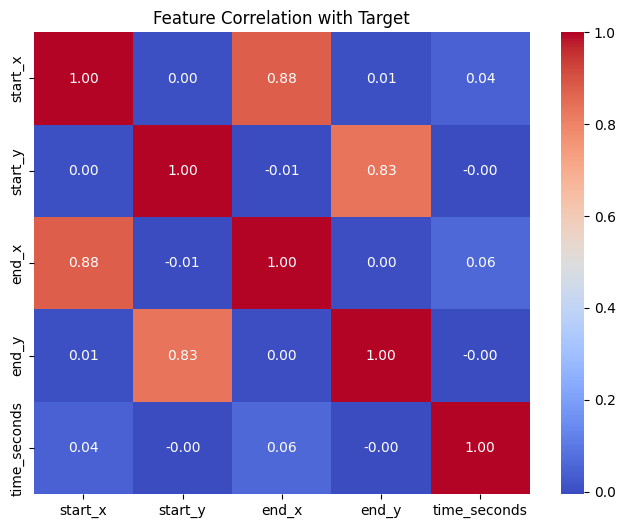

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 상관관계를 볼 컬럼들 선택
# 좌표뿐만 아니라 시간, 선수ID 등도 같이 봅니다.
cols_to_check = ['start_x', 'start_y', 'end_x', 'end_y', 'time_seconds']

# 2. 상관계수 계산 (Pearson Correlation)
corr_matrix = train[cols_to_check].corr()

print("상관계수 행렬:")
print(corr_matrix[['end_x', 'end_y']]) # 정답과 관련된 것만 출력

# 3. 시각화 (히트맵)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Target")
plt.show()

분석할 컬럼들: ['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id', 'player_id', 'action_id', 'start_x', 'start_y', 'end_x', 'end_y']

=== End_X 와의 상관관계 Top 10 ===
end_x           1.000000
start_x         0.876137
action_id       0.078680
episode_id      0.077661
period_id       0.059254
time_seconds    0.058486
player_id       0.035616
team_id         0.015278
start_y         0.005732
end_y           0.001715
Name: end_x, dtype: float64

=== End_Y 와의 상관관계 Top 10 ===
end_y           1.000000
start_y         0.833794
player_id       0.023341
action_id       0.008248
period_id       0.006991
episode_id      0.006416
start_x         0.005805
time_seconds    0.003012
game_id         0.002708
end_x           0.001715
Name: end_y, dtype: float64


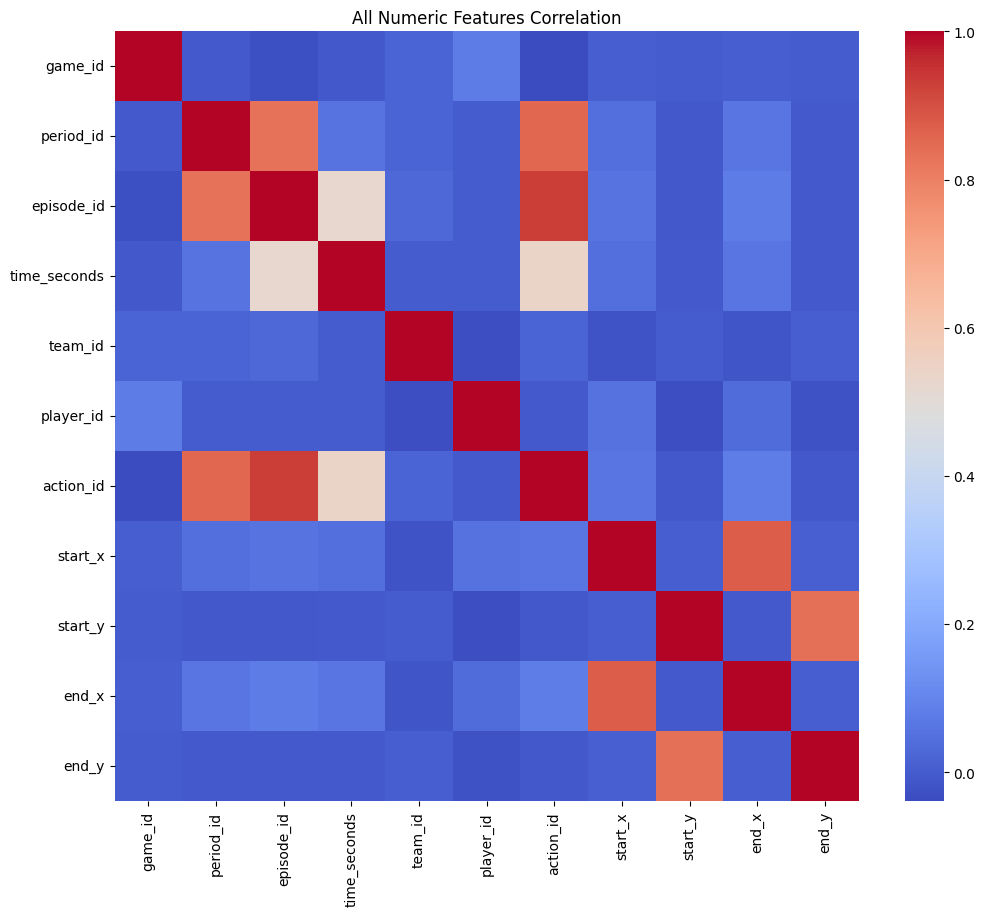

In [42]:
# 모든 숫자형 컬럼 선택
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

print("분석할 컬럼들:", numeric_cols)

# 상관계수 계산
corr_matrix = train[numeric_cols].corr()

# end_x, end_y와 관계가 높은 순서대로 정렬해서 보기
print("\n=== End_X 와의 상관관계 Top 10 ===")
print(corr_matrix['end_x'].abs().sort_values(ascending=False).head(10))

print("\n=== End_Y 와의 상관관계 Top 10 ===")
print(corr_matrix['end_y'].abs().sort_values(ascending=False).head(10))

# 전체 히트맵 (너무 크면 잘 안 보일 수 있으니 주의)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm') # 숫자가 너무 많으니 annot=False
plt.title("All Numeric Features Correlation")
plt.show()

=== Spearman 상관관계 (순위 기반) ===
               end_x     end_y
start_x     0.876571  0.005998
start_y    -0.004254  0.833857
end_x       1.000000  0.002382
end_y       0.002382  1.000000
episode_id  0.080994 -0.006613
period_id   0.061537 -0.007018
action_id   0.082844 -0.008269


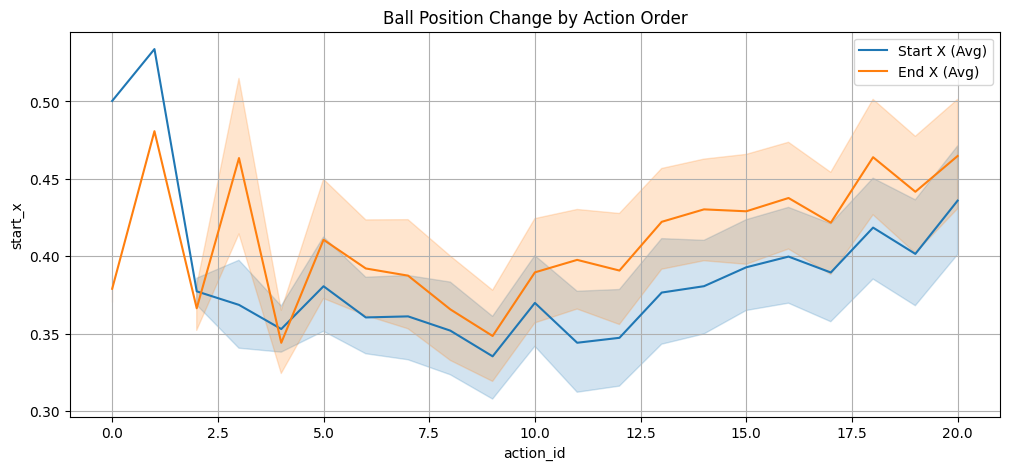

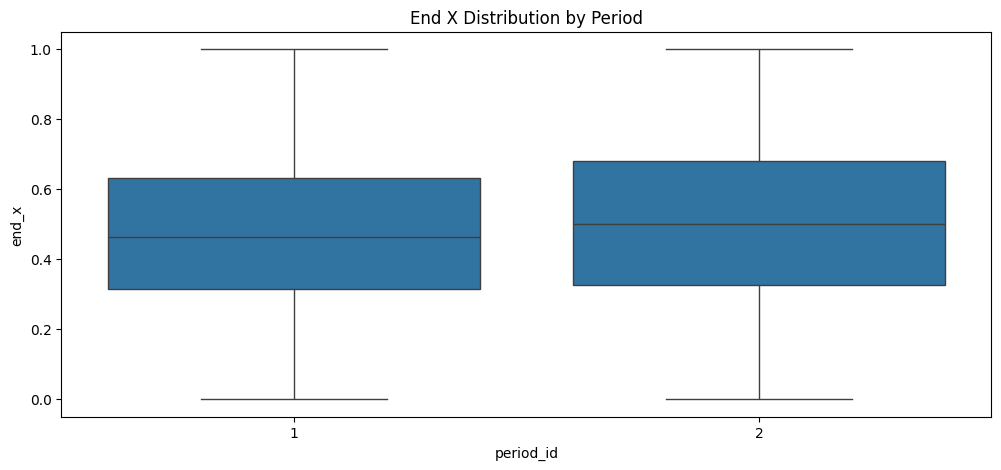

In [43]:
# 분석할 컬럼만 추출
cols = ['start_x', 'start_y', 'end_x', 'end_y', 'episode_id', 'period_id', 'action_id']
df_analysis = train[cols].copy()

# 1. 상관관계 재확인 (Spearman 사용)
# ID값들은 순위(Rank) 정보에 가까우므로 Pearson보다 Spearman이 더 관계를 잘 잡을 수 있습니다.
corr_spearman = df_analysis.corr(method='spearman')

print("=== Spearman 상관관계 (순위 기반) ===")
print(corr_spearman[['end_x', 'end_y']])

# 2. 시각화: Action ID에 따른 Start/End X 변화
# (액션이 진행될수록 공이 어디로 가는가?)
plt.figure(figsize=(12, 5))
data_sample = df_analysis[df_analysis['action_id'] <= 20] # 20번 액션까지만
sns.lineplot(data=data_sample, x='action_id', y='start_x', label='Start X (Avg)')
sns.lineplot(data=data_sample, x='action_id', y='end_x', label='End X (Avg)')
plt.title("Ball Position Change by Action Order")
plt.grid(True)
plt.show()

# 3. 시각화: Period ID에 따른 분포 차이
# 전반/후반에 패스 도착점 분포가 다른가?
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_analysis, x='period_id', y='end_x')
plt.title("End X Distribution by Period")
plt.show()

알겠습니다. 헷갈리지 않게 [Test 데이터 전처리 + 추론 + 제출] 까지 한 번에 끝내는 코드를 드릴게요.
LSTM 모델 학습이 끝난 상태에서(위 코드 실행 후), 아래 코드를 이어서 실행하면 됩니다.

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 1. 데이터 모양 변환 (Reshape for LSTM)
# ----------------------------------------------------------
# X_seq_goal은 현재 (N, 20) 형태로 펴져 있음 -> (N, 5, 4)로 다시 뭉쳐야 함
# 20 = 5 steps * 4 features
X_lstm = X_seq_goal.reshape(-1, 5, 4) 
y_lstm = y_seq_goal # 정답은 그대로 (N, 2)

print(f"LSTM 입력 데이터 Shape: {X_lstm.shape}") # (N, 5, 4)

# 2. 학습/검증 데이터 분할
# ----------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Tensor 변환
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)


# 3. LSTM 모델 정의
# ----------------------------------------------------------
class SoccerLSTM(nn.Module):
    def __init__(self):
        super(SoccerLSTM, self).__init__()
        # input_size=4 (x, y, dist, angle)
        # hidden_size=64 (기억 용량)
        # num_layers=2 (2층 쌓기)
        self.lstm = nn.LSTM(input_size=4, hidden_size=64, num_layers=2, batch_first=True, dropout=0.2)
        
        # LSTM 끝나고 나온 결과로 좌표 예측
        self.fc = nn.Linear(64, 2) 
        
    def forward(self, x):
        # x shape: (Batch, 5, 4)
        
        # lstm_out: (Batch, 5, 64) - 모든 스텝의 출력
        # hidden: (h_n, c_n) - 마지막 상태
        lstm_out, _ = self.lstm(x)
        
        # 우리는 "마지막 스텝"의 결과만 필요함!
        # lstm_out[:, -1, :] -> (Batch, 64)
        last_output = lstm_out[:, -1, :]
        
        # 좌표 예측
        out = self.fc(last_output)
        return out

model = SoccerLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("LSTM 모델 구조:", model)


# 4. 학습 (Training Loop)
# ----------------------------------------------------------
print("\nLSTM 학습 시작...")
epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # 검증
    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            val_out = model(X_val_tensor).numpy()
            # 실제 거리로 환산해서 평가
            diff_x = (val_out[:,0] - y_val[:,0]) * 105.0
            diff_y = (val_out[:,1] - y_val[:,1]) * 68.0
            score = np.mean(np.sqrt(diff_x**2 + diff_y**2))
            print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.5f}, Real Score: {score:.4f}")

print("학습 완료!")


# 5. 추론 및 제출 파일 생성
# ----------------------------------------------------------
# Test 데이터도 변환 필요
# 아까 만든 X_test_seq (Flatten된 상태)를 다시 골대 정보 추가해서 만들어야 함
# (주의: 아까 X_test_seq는 골대 정보가 없었음! 다시 만들어야 함)

LSTM 입력 데이터 Shape: (15435, 5, 4)
LSTM 모델 구조: SoccerLSTM(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

LSTM 학습 시작...
Epoch 5, Loss: 0.03456, Real Score: 17.4915
Epoch 10, Loss: 0.03305, Real Score: 16.9934
Epoch 15, Loss: 0.03249, Real Score: 16.9186
Epoch 20, Loss: 0.03200, Real Score: 16.9482
Epoch 25, Loss: 0.03150, Real Score: 16.7979
Epoch 30, Loss: 0.03118, Real Score: 16.6749
학습 완료!


In [47]:
print(model)

SoccerLSTM(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

# ----------------------------------------------------------
# 1. LSTM 모델 정의 (업그레이드 버전)
# ----------------------------------------------------------
class SoccerLSTM(nn.Module):
    def __init__(self):
        super(SoccerLSTM, self).__init__()
        # input: 4 (x, y, dist, angle)
        # hidden: 128 (용량 2배 증가!)
        # layers: 2
        self.lstm = nn.LSTM(input_size=4, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(128, 2) # 128 -> 2
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :] # 마지막 스텝만 사용
        out = self.fc(last_output)
        return out

# 모델 생성 (이 변수가 끝까지 갑니다!)
model = SoccerLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 학습률 감소 스케줄러 추가 (점수 정체 구간 돌파용)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,)

print("New LSTM Model Created:", model)

# ----------------------------------------------------------
# 2. 데이터 준비 (아까 만든 X_seq_goal 재사용)
# ----------------------------------------------------------
# (N, 20) -> (N, 5, 4) 변환
X_lstm = X_seq_goal.reshape(-1, 5, 4)
y_lstm = y_seq_goal

X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=True)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

# ----------------------------------------------------------
# 3. 학습 (Training)
# ----------------------------------------------------------
print("\n[LSTM 학습 시작]")
epochs = 50 # 좀 더 길게

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # 검증 및 스케줄러 업데이트
    model.eval()
    with torch.no_grad():
        val_out = model(X_val_tensor).numpy()
        diff_x = (val_out[:,0] - y_val[:,0]) * 105.0
        diff_y = (val_out[:,1] - y_val[:,1]) * 68.0
        val_score = np.mean(np.sqrt(diff_x**2 + diff_y**2))
    
    scheduler.step(val_score) # 점수 안 오르면 학습률 낮춤
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:02d}, Loss: {running_loss/len(train_loader):.5f}, Val Score: {val_score:.4f}")

print("학습 완료!")

# ----------------------------------------------------------
# 4. 추론 및 제출 (에러 없이 바로 실행)
# ----------------------------------------------------------
print("\n[추론 및 제출 파일 생성]")
test_meta = pd.read_csv("../open_track1/test.csv")
base_path = "../open_track1"
GOAL_X, GOAL_Y = 1.0, 0.5

final_predictions_x = []
final_predictions_y = []

model.eval()
with torch.no_grad():
    for idx, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
        file_path = os.path.join(base_path, row['path'][2:])
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path)
            
            # 전처리 (정규화 + 골대정보 + 시퀀스)
            temp_df['start_x'] /= 105.0
            temp_df['start_y'] /= 68.0
            coords = temp_df[['start_x', 'start_y']].values
            
            dist = np.sqrt((coords[:,0]-GOAL_X)**2 + (coords[:,1]-GOAL_Y)**2).reshape(-1,1)
            angle = np.arctan2(coords[:,1]-GOAL_Y, coords[:,0]-GOAL_X).reshape(-1,1)
            features = np.hstack([coords, dist, angle])
            
            if len(features) >= 5:
                seq = features[-5:]
            else:
                padding = np.zeros((5 - len(features), 4))
                seq = np.vstack([padding, features])
            
            # (1, 5, 4) 입력
            input_tensor = torch.FloatTensor(seq).unsqueeze(0)
            pred = model(input_tensor).numpy()
            
            final_predictions_x.append(pred[0,0] * 105.0)
            final_predictions_y.append(pred[0,1] * 68.0)
        else:
            final_predictions_x.append(52.5)
            final_predictions_y.append(34.0)

sub = pd.read_csv("../open_track1/sample_submission.csv")
sub['end_x'] = final_predictions_x
sub['end_y'] = final_predictions_y
save_path = "../open_track1/submission_lstm_v2.csv"
sub.to_csv(save_path, index=False)
print(f"저장 완료: {save_path}")

New LSTM Model Created: SoccerLSTM(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

[LSTM 학습 시작]
Epoch 05, Loss: 0.03444, Val Score: 17.6675
Epoch 10, Loss: 0.03319, Val Score: 17.1404
Epoch 15, Loss: 0.03250, Val Score: 17.2468
Epoch 20, Loss: 0.03211, Val Score: 17.1188
Epoch 25, Loss: 0.03154, Val Score: 16.9362
Epoch 30, Loss: 0.03087, Val Score: 16.7190
Epoch 35, Loss: 0.03067, Val Score: 16.5887
Epoch 40, Loss: 0.03040, Val Score: 16.5891
Epoch 45, Loss: 0.03021, Val Score: 16.4917
Epoch 50, Loss: 0.03012, Val Score: 16.4603
학습 완료!

[추론 및 제출 파일 생성]


100%|██████████| 2414/2414 [00:11<00:00, 210.39it/s]

저장 완료: ../open_track1/submission_lstm_v2.csv


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

# ----------------------------------------------------------
# 1. 데이터 전처리 (Action ID 추가!)
# ----------------------------------------------------------
print("데이터 전처리 시작 (Action ID 포함)...")
train = pd.read_csv("../open_track1/train.csv")

# 정규화
train['start_x'] = train['start_x'] / 105.0
train['start_y'] = train['start_y'] / 68.0
train['end_x'] = train['end_x'] / 105.0
train['end_y'] = train['end_y'] / 68.0

# Action ID도 정규화 (최대값이 대략 50 정도니까 50으로 나눔)
train['action_id'] = train['action_id'] / 50.0

def create_sequence_data_final(df, seq_len=5):
    sequences = []
    targets = []
    GOAL_X, GOAL_Y = 1.0, 0.5
    
    grouped = df.groupby('game_episode')
    for name, group in tqdm(grouped, desc="시퀀스 생성"):
        coords = group[['start_x', 'start_y']].values
        # Action ID 추가
        actions = group['action_id'].values.reshape(-1, 1)
        
        # 거리, 각도
        dist = np.sqrt((coords[:,0]-GOAL_X)**2 + (coords[:,1]-GOAL_Y)**2).reshape(-1,1)
        angle = np.arctan2(coords[:,1]-GOAL_Y, coords[:,0]-GOAL_X).reshape(-1,1)
        
        # 5개 피처 합치기: [x, y, dist, angle, action_id]
        features = np.hstack([coords, dist, angle, actions])
        
        last_action = group.iloc[-1]
        target = [last_action['end_x'], last_action['end_y']]
        
        if len(features) >= seq_len:
            seq = features[-seq_len:]
        else:
            padding = np.zeros((seq_len - len(features), 5)) # 5개 피처!
            seq = np.vstack([padding, features])
            
        sequences.append(seq.flatten())
        targets.append(target)
        
    return np.array(sequences), np.array(targets)

X_seq_final, y_seq_final = create_sequence_data_final(train, seq_len=5)
print(f"입력 데이터 Shape: {X_seq_final.shape}")

# ----------------------------------------------------------
# 2. LSTM 모델 (입력 5 -> 128)
# ----------------------------------------------------------
X_lstm = X_seq_final.reshape(-1, 5, 5) # (N, 5, 5)
y_lstm = y_seq_final

X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=True)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

class FinalLSTM(nn.Module):
    def __init__(self):
        super(FinalLSTM, self).__init__()
        # input_size=5 (x, y, dist, angle, action_id)
        self.lstm = nn.LSTM(input_size=5, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(128, 2)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out

model = FinalLSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ----------------------------------------------------------
# 3. 학습
# ----------------------------------------------------------
print("\n[Final LSTM 학습 시작]")
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        val_out = model(X_val_tensor).numpy()
        diff_x = (val_out[:,0] - y_val[:,0]) * 105.0
        diff_y = (val_out[:,1] - y_val[:,1]) * 68.0
        val_score = np.mean(np.sqrt(diff_x**2 + diff_y**2))
    
    scheduler.step(val_score)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:02d}, Loss: {running_loss/len(train_loader):.5f}, Val Score: {val_score:.4f}")

# ----------------------------------------------------------
# 4. 추론 및 제출
# ----------------------------------------------------------
print("\n[추론 시작]")
test_meta = pd.read_csv("../open_track1/test.csv")
base_path = "../open_track1"
GOAL_X, GOAL_Y = 1.0, 0.5

final_predictions_x = []
final_predictions_y = []

model.eval()
with torch.no_grad():
    for idx, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
        file_path = os.path.join(base_path, row['path'][2:])
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path)
            
            # 정규화
            temp_df['start_x'] /= 105.0
            temp_df['start_y'] /= 68.0
            # Action ID 정규화 (학습 때랑 똑같이 50으로 나눔)
            # 만약 action_id 컬럼이 없으면 인덱스로 대체
            if 'action_id' in temp_df.columns:
                temp_df['action_id'] = temp_df['action_id'] / 50.0
            else:
                # 테스트 파일에 action_id가 없는 경우 인덱스를 사용 (0부터 시작)
                temp_df['action_id'] = temp_df.index / 50.0

            coords = temp_df[['start_x', 'start_y']].values
            actions = temp_df['action_id'].values.reshape(-1, 1)
            
            dist = np.sqrt((coords[:,0]-GOAL_X)**2 + (coords[:,1]-GOAL_Y)**2).reshape(-1,1)
            angle = np.arctan2(coords[:,1]-GOAL_Y, coords[:,0]-GOAL_X).reshape(-1,1)
            
            features = np.hstack([coords, dist, angle, actions])
            
            if len(features) >= 5:
                seq = features[-5:]
            else:
                padding = np.zeros((5 - len(features), 5))
                seq = np.vstack([padding, features])
            
            input_tensor = torch.FloatTensor(seq).unsqueeze(0)
            pred = model(input_tensor).numpy()
            
            final_predictions_x.append(pred[0,0] * 105.0)
            final_predictions_y.append(pred[0,1] * 68.0)
        else:
            final_predictions_x.append(52.5)
            final_predictions_y.append(34.0)

sub = pd.read_csv("../open_track1/sample_submission.csv")
sub['end_x'] = final_predictions_x
sub['end_y'] = final_predictions_y
save_path = "../open_track1/submission_lstm_final.csv"
sub.to_csv(save_path, index=False)
print(f"저장 완료: {save_path}")

데이터 전처리 시작 (Action ID 포함)...


시퀀스 생성: 100%|██████████| 15435/15435 [00:05<00:00, 2660.17it/s]


입력 데이터 Shape: (15435, 25)

[Final LSTM 학습 시작]
Epoch 05, Loss: 0.03555, Val Score: 18.1680
Epoch 10, Loss: 0.03383, Val Score: 17.3475
Epoch 15, Loss: 0.03301, Val Score: 17.1563
Epoch 20, Loss: 0.03167, Val Score: 16.6914
Epoch 25, Loss: 0.03131, Val Score: 16.8686
Epoch 30, Loss: 0.03065, Val Score: 16.6999
Epoch 35, Loss: 0.03058, Val Score: 16.6355
Epoch 40, Loss: 0.03036, Val Score: 16.8520
Epoch 45, Loss: 0.03014, Val Score: 16.7202
Epoch 50, Loss: 0.03013, Val Score: 16.7125

[추론 시작]


100%|██████████| 2414/2414 [00:14<00:00, 171.56it/s]

저장 완료: ../open_track1/submission_lstm_final.csv


시각화 계획
경기장 그리기: 녹색 잔디 대신 흰색 바탕 + 검정 테두리 (깔끔하게)
골대 표시: 좌우 끝에 골대 박스 그리기
궤적 그리기 (Gradient):
시작점(Start): 검정색 (진하게)
끝점(End): 점점 흐려지거나 밝은 색으로 변하게
이렇게 하면 시간의 흐름(방향)이 한눈에 보입니다.
아래 코드는 train.csv에서 랜덤으로 에피소드 하나를 뽑아서 경기장 위에 그려주는 코드입니다.
여러 번 실행해서 다양한 패턴을 구경해 보세요!

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import random

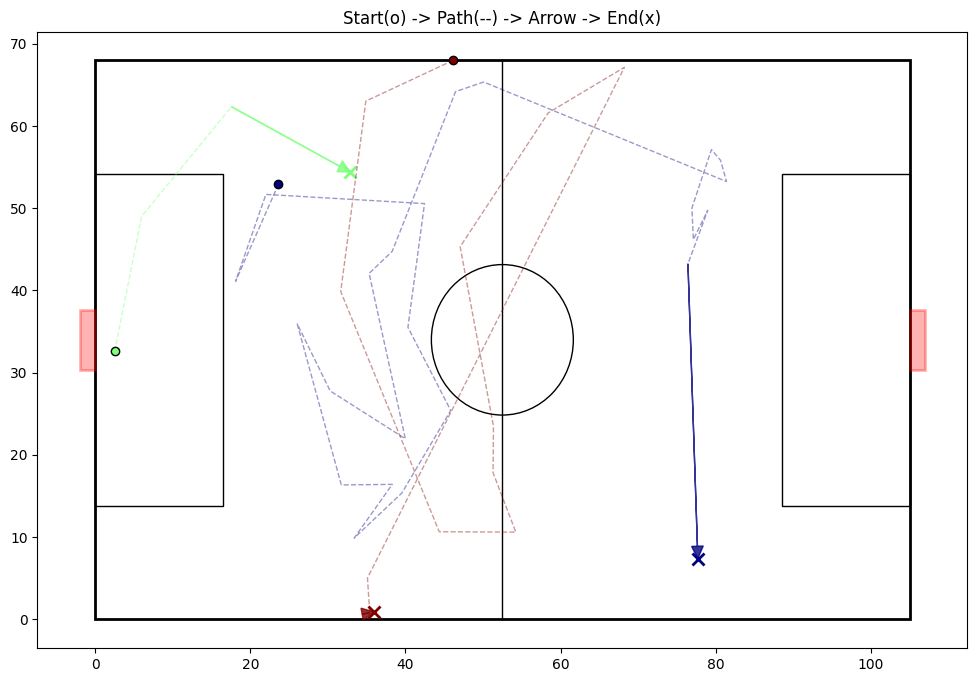

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

# 1. 경기장 그리는 함수
def draw_pitch(ax):
    # 경기장 크기 (105 x 68)
    # 흰색 바탕, 검정 테두리
    
    # 메인 사각형 (경기장)
    rect = patches.Rectangle((0, 0), 105, 68, linewidth=2, edgecolor='black', facecolor='white')
    ax.add_patch(rect)
    
    # 중앙선
    ax.plot([52.5, 52.5], [0, 68], color='black', linewidth=1)
    # 센터 서클
    circle = patches.Circle((52.5, 34), 9.15, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(circle)
    
    # 페널티 박스 (좌측)
    ax.add_patch(patches.Rectangle((0, 34-20.16), 16.5, 40.32, linewidth=1, edgecolor='black', facecolor='none'))
    # 페널티 박스 (우측)
    ax.add_patch(patches.Rectangle((105-16.5, 34-20.16), 16.5, 40.32, linewidth=1, edgecolor='black', facecolor='none'))
    
    # 골대 (좌측, 우측) - 빨간색으로 강조
    ax.add_patch(patches.Rectangle((-2, 34-3.66), 2, 7.32, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3))
    ax.add_patch(patches.Rectangle((105, 34-3.66), 2, 7.32, linewidth=2, edgecolor='red', facecolor='red', alpha=0.3))

# 2. 궤적 그리는 함수
def plot_final_viz(num_episodes=3): # 30개 정도가 깔끔함
    df_raw = pd.read_csv("../open_track1/train.csv")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    episode_ids = random.sample(df_raw['game_episode'].unique().tolist(), num_episodes)
    colors = cm.jet(np.linspace(0, 1, num_episodes)) # 좀 더 진한 색감(jet)
    
    for i, ep_id in enumerate(episode_ids):
        data = df_raw[df_raw['game_episode'] == ep_id].sort_values('time_seconds')
        
        x = data['start_x'].values
        y = data['start_y'].values
        last_end_x = data.iloc[-1]['end_x']
        last_end_y = data.iloc[-1]['end_y']
        c = colors[i]
        
        # 1. 궤적
        ax.plot(x, y, color=c, alpha=0.4, linewidth=1, linestyle='--')
        
        # 2. ★시작점 (O)★ - 에피소드의 맨 처음 시작
        ax.plot(x[0], y[0], marker='o', color=c, markersize=6, markeredgecolor='black')
        
        # 3. 마지막 화살표
        dx = last_end_x - x[-1]
        dy = last_end_y - y[-1]
        ax.arrow(x[-1], y[-1], dx, dy, 
                 head_width=1.5, head_length=1.5, fc=c, ec=c, alpha=0.8, length_includes_head=True)
        
        # 4. ★도착점 (X)★ - 에피소드의 맨 마지막 끝
        ax.plot(last_end_x, last_end_y, marker='x', color=c, markersize=8, markeredgewidth=2)

    plt.title(f"Start(o) -> Path(--) -> Arrow -> End(x)")
    plt.show()

plot_final_viz(3)

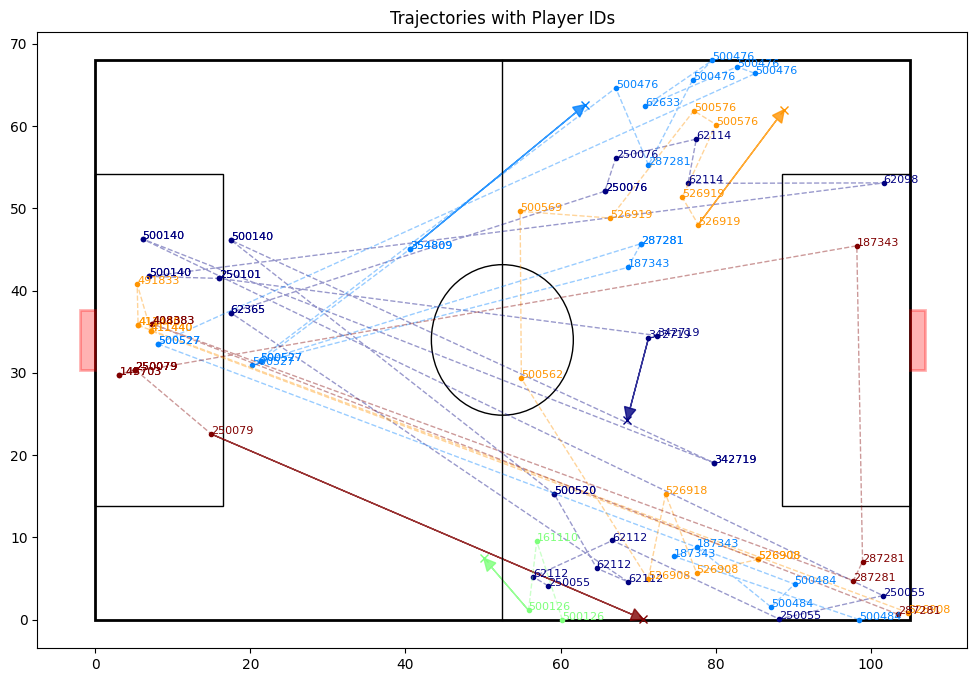

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random


    
def plot_final_viz_with_player(num_episodes=5):
    df_raw = pd.read_csv("../open_track1/train.csv")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    episode_ids = random.sample(df_raw['game_episode'].unique().tolist(), num_episodes)
    colors = cm.jet(np.linspace(0, 1, num_episodes))
    
    for i, ep_id in enumerate(episode_ids):
        data = df_raw[df_raw['game_episode'] == ep_id].sort_values('time_seconds')
        
        # 데이터 추출
        x = data['start_x'].values
        y = data['start_y'].values
        players = data['player_id'].values # 선수 ID
        
        last_end_x = data.iloc[-1]['end_x']
        last_end_y = data.iloc[-1]['end_y']
        c = colors[i]
        
        # 궤적
        ax.plot(x, y, color=c, alpha=0.4, linewidth=1, linestyle='--')
        
        # 각 지점마다 선수 ID 표시
        for j in range(len(x)):
            # 점 찍기
            ax.plot(x[j], y[j], marker='.', color=c)
            # 글자 쓰기 (ID)
            ax.text(x[j], y[j], str(players[j]), fontsize=8, color=c)
            
        # 마지막 화살표
        dx = last_end_x - x[-1]
        dy = last_end_y - y[-1]
        ax.arrow(x[-1], y[-1], dx, dy, 
                 head_width=1.5, head_length=1.5, fc=c, ec=c, alpha=0.8, length_includes_head=True)
        ax.plot(last_end_x, last_end_y, marker='x', color=c)

    plt.title(f"Trajectories with Player IDs")
    plt.show()

plot_final_viz_with_player(5)